In [19]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [20]:
df = pd.read_csv('thefts_2011_2013.csv')

In [21]:
data_colms = ['Total Population','Community Area','Latitude','Longitude']

In [22]:
X_data = df.groupby(['Community Area']).mean().reset_index()\
[data_colms]

What I am trying to do here is to get a weekly rate and then find the average weekly rate. The weekly rate is the number of counts for a given week of the year in a given community area. This is then averaged over all the weeks of the year for which we have data for a community area.

In [23]:
y_data = df.groupby(['Community Area','Week'])\
            .sum().reset_index()\
            .groupby('Community Area').mean().reset_index()

In [24]:
test_rows = np.random.randint(0,77,size=3)

In [25]:
#Sanity tests

print(X_data.shape[0])
print(y_data.shape[0])
print()
delta = 1e-6
for row in test_rows:
    data_row = X_data.ix[row]
    ca = data_row['Community Area']
    df_rows = df[df['Community Area']==ca]
    print('CA ' + str(ca))
    print('-'*10)
    for colm in data_colms:
        assert abs(data_row[colm] - df_rows[colm].mean()) <= delta
        print(colm + ' \/')
        print(data_row[colm],df_rows[colm].mean())
    
    assert abs(
        y_data.ix[row].Count - df_rows.groupby('Week')['Count'].sum().mean()
    ) <= delta
    print('Count'+ ' \/')
    print(y_data.ix[row].Count,df_rows.groupby('Week')['Count'].sum().mean())
    
    print()
print('Sanity tests ok')

77
77

CA 55.0
----------
Total Population \/
9426.0 9426.0
Community Area \/
55.0 55.0
Latitude \/
41.6592436072 41.6592436072
Longitude \/
-87.5462255953 -87.5462255953
Count \/
9.39622641509 9.39622641509

CA 50.0
----------
Total Population \/
7325.0 7325.0
Community Area \/
50.0 50.0
Latitude \/
41.7055334537 41.7055334537
Longitude \/
-87.6016658508 -87.6016658508
Count \/
12.5660377358 12.5660377358

CA 50.0
----------
Total Population \/
7325.0 7325.0
Community Area \/
50.0 50.0
Latitude \/
41.7055334537 41.7055334537
Longitude \/
-87.6016658508 -87.6016658508
Count \/
12.5660377358 12.5660377358

Sanity tests ok


Total duration ranges from Jan 1st 2001 to Jan 31st 2017 so 5874 days = 839 weeks. This gives us the following weekly and per population theft rates

In [26]:
weekly_rate = 1561.53626149132
pop_weekly_rate = 0.000579291222760708
total_pop = 2695598

In [27]:
expected_count = X_data['Total Population']*pop_weekly_rate

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
inputs  = X_data[['Latitude','Longitude']].as_matrix()
outputs = y_data['Count'].values

Here fitting for all the examples

In [30]:
n = inputs.shape[0]
K = tt.zeros((n,n))
with pm.Model() as model:
    l_spatial = pm.StudentTpos('l_s',nu=4,mu=0.1,lam=1.)
    sd_spatial = pm.StudentTpos('sd_s',nu=4,mu=0.1,lam=1.)
    sigma_spatial = pm.Deterministic('sigma_s',sd_spatial**2)
    cov_spatial = pm.gp.cov.Matern32(2, l_spatial)
    noise_spatial = (sigma_spatial)*tt.eye(n)
    f = pm.MvNormal('f',mu=np.zeros((n,)),
         cov=cov_spatial(inputs)+noise_spatial,shape=n)
    rel_risk = pm.Deterministic('exp_f',tt.exp(f))
    lam = pm.Deterministic('lam',rel_risk*expected_count)
    y = pm.Poisson('y',mu=lam,observed=outputs)
                        

In [32]:
with model:
    trace = pm.sample(5000)

100%|██████████| 5000/5000 [02:29<00:00, 33.39it/s]


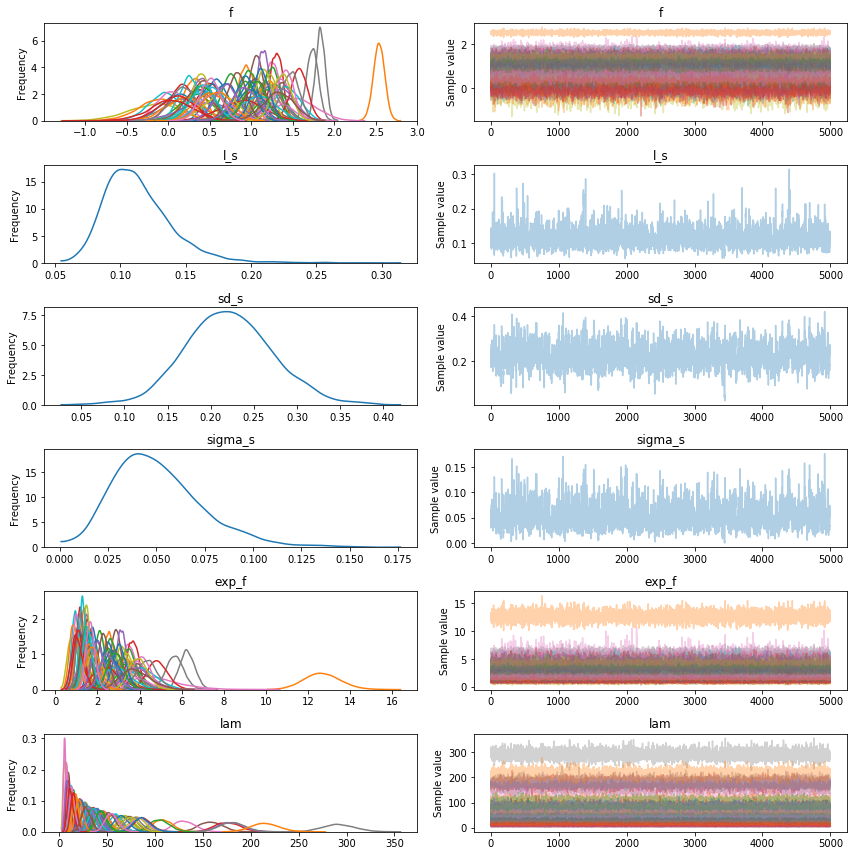

In [33]:
%matplotlib inline
pm.traceplot(trace);

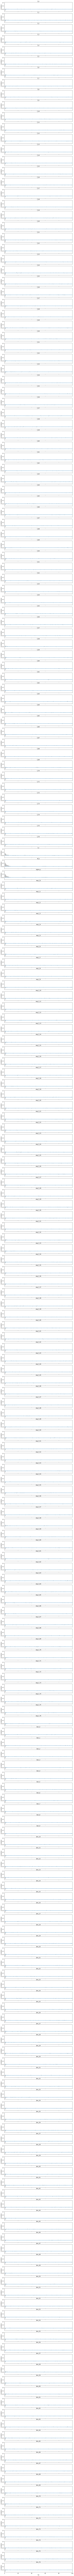

In [34]:
pm.autocorrplot(trace);

In [37]:
import json
with open("/users/user/downloads/Boundaries - Community Areas (current).geojson",'r') as fp:
    cadata = json.load(fp)

areas = y_data['Community Area']
cm = plt.get_cmap('Reds')
obsv_risk = outputs/expected_count.values
pred_risk = trace['exp_f'].mean(axis=0)
max_risk = max(np.max(obsv_risk),np.max(pred_risk))
colors= [dict(zip(areas,cm((obsv_risk/max_risk).flatten()))),
         dict(zip(areas,cm((pred_risk/max_risk).flatten())))]
titles = ['Observed Relative Risk','Predicted Relative Risk']

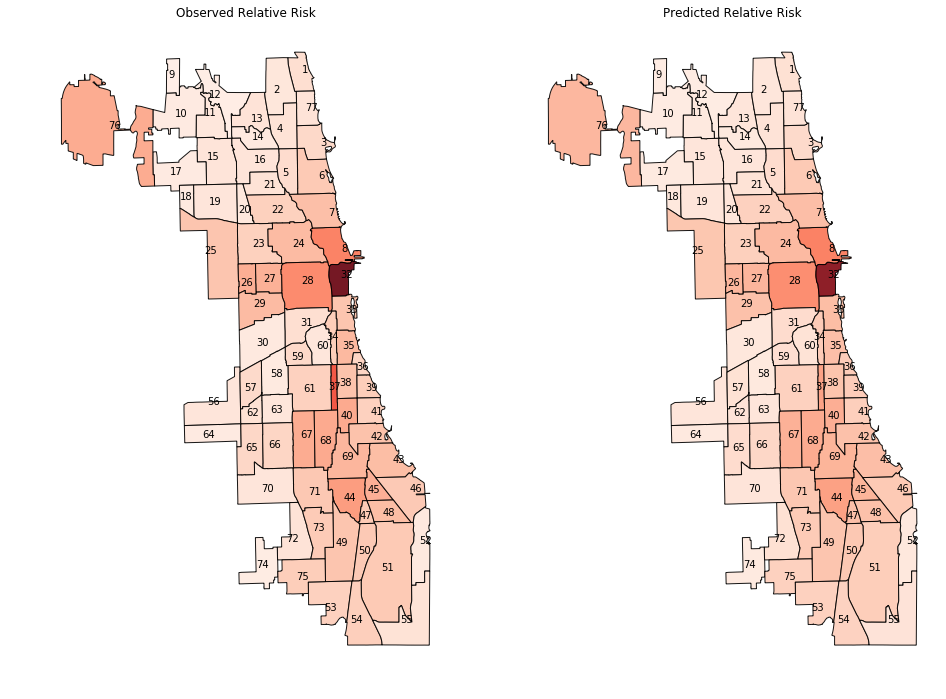

In [38]:
fig = plt.figure(figsize=(16,12)) 
for feat in ((cadata['features'])):
    x_,y_ = zip(*feat['geometry']['coordinates'][0][0])
    ca = int(feat['properties']['area_num_1'])
    for i in range(2):
        plt.subplot(1,2,i+1)
        color = colors[i][ca]
        polygon = plt.fill(x_,y_,
             c=color,alpha=0.9)[0]
        polygon.set_ec('k')
        fontdict = {}
        plt.text(np.mean(x_),np.mean(y_),ca,
                 horizontalalignment='center',
                 verticalalignment='center',**fontdict)
        plt.title(titles[i])
        fig.axes[i].set_frame_on(False)
        fig.axes[i].set_axis_off()